### Transformer Encoder model
> KU-HAR dataset | with sinosiudal and random position encoding | __Full-action set__

In [1]:
import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Loading packages ...")

import os
import sys
import time
import pickle
import json
from argparse import Namespace

# 3rd party packages
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Project modules
from src.options import Options
from src.running import setup, pipeline_factory, validate, check_progress, NEG_METRICS
from src.utils import utils
from src.datasets.data import data_factory, Normalizer
from src.datasets.datasplit import split_dataset
from src.models.ts_transformer import model_factory
from src.models.loss import get_loss_module
from src.optimizers import get_optimizer

import neptune.new as neptune

2022-09-15 22:31:06,349 | INFO : Loading packages ...


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
run = neptune.init(
    project="FYP-Group22/Transformer-SSC",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/Transformer-SSC/e/TRAN-11
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
config = {}
config["output_dir"] = './tmp'
config["seed"] = 123
config["gpu"] = "0" # activate gpu > o, on cpu > -1
config["n_proc"] = 1

# loading pre-trained model
config["load_model"] = None
config["test_only"] = None
config["config_filepath"] = None

# experiment config
config["task"] = "classification"
config["experiment_name"] = "first_test"
config["no_timestamp"] = True

# dataset settings
config["limit_size"] = 300 
config["data_class"] = 'kuhar'
config["data_dir"] = '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv'
config["val_ratio"] = 0.1 
config["test_ratio"] = 0.1 
config["norm_from"] = False 
config["normalization"] = 'standardization'
config["record_file"] = "./tmp/Imputation_records.xls"
config["records_file"] = "./tmp/records.xls"
config["num_workers"] = 0
config["console"] = True
config["save_all"] = False
config["comment"] = "mvts_transformer | KU-HAR dataset Dynamic Actions | nipdep 1DConv processing layer | first test"

# test, val from seperate files 
config["test_pattern"] = False 
config["val_pattern"] = False 
config["test_from"] = False

# freeze model weight for fine-tunning
config["freeze"] = False

# if task is a imputation 
config["masking_ratio"] = 0.15
config["mean_mask_length"] = 5
config["mask_mode"] = "seperate"
config["mask_distribution"] = "geometric"
config["exclude_feats"] = None 
config["mask_feats"] = '0, 1'
config["start_hint"] = 0.0
config["end_hint"] = 0.0 
config["harden"] = True

# model parameters
config['model'] = 'transformer'
config["pos_encoding"] = "learnable"
config["d_model"] = 128 
config["dim_feedforward"] = 256
config["num_heads"] = 8
config["num_layers"] = 3
config["dropout"] = 0.1
config["activation"] = 'relu'
config["normalization_layer"] = "BatchNorm"
config["data_window_len"] = None 
config["max_seq_len"] = 300

# model training parameters
config["epochs"] = 10
config["lr"] = 0.0005
config["val_interval"] = 1
config["lr_step"] = '1000'
config["lr_factor"] = '0.1'
config["l2_reg"] = 0
config["global_reg"] = True
config["key_metric"] = "loss"
config["optimizer"] = "Adam"
config["batch_size"] = 32
config["print_interval"] = 1

setup(config)

2022-09-15 22:31:20,766 | INFO : Stored configuration file in './tmp\first_test'


{'output_dir': './tmp\\first_test',
 'seed': 123,
 'gpu': '0',
 'n_proc': 1,
 'load_model': None,
 'test_only': None,
 'config_filepath': None,
 'task': 'classification',
 'experiment_name': 'first_test',
 'no_timestamp': True,
 'limit_size': 300,
 'data_class': 'kuhar',
 'data_dir': '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv',
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'norm_form': False,
 'normalization': None,
 'record_file': './tmp/Imputation_records.xls',
 'records_file': './tmp/records.xls',
 'num_workers': 0,
 'console': True,
 'save_all': False,
 'comment': 'mvts_transformer | KU-HAR dataset Dynamic Actions | nipdep 1DConv processing layer | first test',
 'test_pattern': False,
 'val_pattern': False,
 'test_from': False,
 'norm_from': False,
 'freeze': False,
 'masking_ratio': 0.15,
 'mean_mask_length': 5,
 'mask_mode': 'seperate',
 'mask_distribution': 'geometric',
 'exclude_feats': None,
 'mask_feats': '0, 1',
 'start_hint': 0.0,
 'end_hint': 0.0,
 'harden': True,
 

In [4]:
run["parameters"] = config
# config['class_names'] = ['Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']
config['class_names'] = ['Stand', 'Sit', 'Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']

In [5]:
total_epoch_time = 0
total_eval_time = 0

total_start_time = time.time()

# Add file logging besides stdout
file_handler = logging.FileHandler(os.path.join(config['output_dir'], 'output.log'))
logger.addHandler(file_handler)

logger.info('Running:\n{}\n'.format(' '.join(sys.argv)))  # command used to run

if config['seed'] is not None:
    torch.manual_seed(config['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info("Using device: {}".format(device))
if device == 'cuda':
    logger.info("Device index: {}".format(torch.cuda.current_device()))

2022-09-15 22:31:20,889 | INFO : Running:
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"44b5f05b-0fd5-4cc6-9199-890a72f7fafc" --shell=9002 --transport="tcp" --iopub=9004 --f=c:\Users\deela\AppData\Roaming\jupyter\runtime\kernel-v2-4860idsACJazxiJP.json

2022-09-15 22:31:20,939 | INFO : Using device: cuda


In [6]:
# Build data
logger.info("Loading and preprocessing data ...")
data_class = data_factory[config['data_class']]
my_data = data_class(config['data_dir'], n_proc=config['n_proc'], limit_size=config['limit_size'], config=config, filter_classes=[])
feat_dim = my_data.feature_df.shape[1]  # dimensionality of data features
if config['task'] == 'classification':
    validation_method = 'StratifiedShuffleSplit'
    labels = my_data.labels_df.label.values
    print(labels)
else:
    validation_method = 'ShuffleSplit'
    labels = None

2022-09-15 22:31:21,084 | INFO : Loading and preprocessing data ...


[0 0 0 ... 9 9 9]


In [7]:
# Split dataset
test_data = my_data
test_indices = None  # will be converted to empty list in `split_dataset`, if also test_set_ratio == 0
val_data = my_data
val_indices = []
if config['test_pattern']:  # used if test data come from different files / file patterns
    test_data = data_class(config['data_dir'], n_proc=-1, config=config)
    test_indices = test_data.all_IDs
if config['test_from']:  # load test IDs directly from file, if available, otherwise use `test_set_ratio`. Can work together with `test_pattern`
    test_indices = list(set([line.rstrip() for line in open(config['test_from']).readlines()]))
    try:
        test_indices = [int(ind) for ind in test_indices]  # integer indices
    except ValueError:
        pass  # in case indices are non-integers
    logger.info("Loaded {} test IDs from file: '{}'".format(len(test_indices), config['test_from']))
if config['val_pattern']:  # used if val data come from different files / file patterns
    val_data = data_class(config['data_dir'], n_proc=-1, config=config)
    val_indices = val_data.all_IDs

# Note: currently a validation set must exist, either with `val_pattern` or `val_ratio`
# Using a `val_pattern` means that `val_ratio` == 0 and `test_ratio` == 0
if config['val_ratio'] > 0:
    train_indices, val_indices, test_indices = split_dataset(data_indices=my_data.all_IDs,
                                                                validation_method=validation_method,
                                                                n_splits=1,
                                                                validation_ratio=config['val_ratio'],
                                                                test_set_ratio=config['test_ratio'],  # used only if test_indices not explicitly specified
                                                                test_indices=test_indices,
                                                                random_seed=1337,
                                                                labels=labels)
    train_indices = train_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
    val_indices = val_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
else:
    train_indices = my_data.all_IDs
    if test_indices is None:
        test_indices = []

logger.info("{} samples may be used for training".format(len(train_indices)))
logger.info("{} samples will be used for validation".format(len(val_indices)))
logger.info("{} samples will be used for testing".format(len(test_indices)))

with open(os.path.join(config['output_dir'], 'data_indices.json'), 'w') as f:
    try:
        json.dump({'train_indices': list(map(int, train_indices)),
                    'val_indices': list(map(int, val_indices)),
                    'test_indices': list(map(int, test_indices))}, f, indent=4)
    except ValueError:  # in case indices are non-integers
        json.dump({'train_indices': list(train_indices),
                    'val_indices': list(val_indices),
                    'test_indices': list(test_indices)}, f, indent=4)

2022-09-15 22:33:15,985 | INFO : 16806 samples may be used for training
2022-09-15 22:33:15,986 | INFO : 1868 samples will be used for validation
2022-09-15 22:33:15,987 | INFO : 2075 samples will be used for testing


In [8]:
# Pre-process features
normalizer = None
if config['norm_from']:
    with open(config['norm_from'], 'rb') as f:
        norm_dict = pickle.load(f)
    normalizer = Normalizer(**norm_dict)
elif config['normalization'] is not None:
    normalizer = Normalizer(config['normalization'])
    my_data.feature_df.loc[train_indices] = normalizer.normalize(my_data.feature_df.loc[train_indices])
    if not config['normalization'].startswith('per_sample'):
        # get normalizing values from training set and store for future use
        norm_dict = normalizer.__dict__
        with open(os.path.join(config['output_dir'], 'normalization.pickle'), 'wb') as f:
            pickle.dump(norm_dict, f, pickle.HIGHEST_PROTOCOL)
if normalizer is not None:
    if len(val_indices):
        print("Validation dataset normalization")
        val_data.feature_df.loc[val_indices] = normalizer.normalize(val_data.feature_df.loc[val_indices])
    if len(test_indices):
        print("Test dataset normalization")
        test_data.feature_df.loc[test_indices] = normalizer.normalize(test_data.feature_df.loc[test_indices])

In [9]:
# Create model
logger.info("Creating model ...")
model = model_factory(config, my_data)

if config['freeze']:
    for name, param in model.named_parameters():
        if name.startswith('output_layer'):
            param.requires_grad = True
        else:
            param.requires_grad = False

logger.info("Model:\n{}".format(model))
logger.info("Total number of parameters: {}".format(utils.count_parameters(model)))
logger.info("Trainable parameters: {}".format(utils.count_parameters(model, trainable=True)))


2022-09-15 22:33:16,178 | INFO : Creating model ...
2022-09-15 22:33:16,190 | INFO : Model:
TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
      

In [10]:
# Initialize optimizer

if config['global_reg']:
    weight_decay = config['l2_reg']
    output_reg = None
else:
    weight_decay = 0
    output_reg = config['l2_reg']

optim_class = get_optimizer(config['optimizer'])
optimizer = optim_class(model.parameters(), lr=config['lr'], weight_decay=weight_decay)

start_epoch = 0
lr_step = 0  # current step index of `lr_step`
lr = config['lr']  # current learning step
# Load model and optimizer state
if config["load_model"]:
    model, optimizer, start_epoch = utils.load_model(model, config['load_model'], optimizer, config['resume'],
                                                        config['change_output'],
                                                        config['lr'],
                                                        config['lr_step'],
                                                        config['lr_factor'])
model.to(device)

loss_module = get_loss_module(config)

if config['test_only'] == 'testset':  # Only evaluate and skip training
    dataset_class, collate_fn, runner_class = pipeline_factory(config)
    test_dataset = dataset_class(test_data, test_indices)

    test_loader = DataLoader(dataset=test_dataset,
                                batch_size=config['batch_size'],
                                shuffle=False,
                                num_workers=config['num_workers'],
                                pin_memory=True,
                                collate_fn=lambda x: collate_fn(x, max_len=model.max_len))
    test_evaluator = runner_class(model, test_loader, device, loss_module,
                                        print_interval=config['print_interval'], console=config['console'])
    aggr_metrics_test, per_batch_test = test_evaluator.evaluate(keep_all=True)
    print_str = 'Test Summary: '
    for k, v in aggr_metrics_test.items():
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    # return

In [11]:
# Initialize data generators
dataset_class, collate_fn, runner_class = pipeline_factory(config)
val_dataset = dataset_class(val_data, val_indices)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config['batch_size'],
                        shuffle=False,
                        num_workers=config['num_workers'],
                        pin_memory=True,
                        collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

train_dataset = dataset_class(my_data, train_indices)

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=config['batch_size'],
                            shuffle=True,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

trainer = runner_class(model, train_loader, device, loss_module, optimizer, l2_reg=output_reg,
                                print_interval=config['print_interval'], console=config['console'])
val_evaluator = runner_class(model, val_loader, device, loss_module,
                                    print_interval=config['print_interval'], console=config['console'])

tensorboard_writer = SummaryWriter(config['tensorboard_dir'])

best_value = 1e16 if config['key_metric'] in NEG_METRICS else -1e16  # initialize with +inf or -inf depending on key metric
metrics = []  # (for validation) list of lists: for each epoch, stores metrics like loss, ...
best_metrics = {}

In [12]:
# for i in train_loader:
#     print(i)
#     break

2022-09-15 22:33:25,215 | INFO : Evaluating on validation set ...


Evaluating Epoch 0  98.3% | batch:        58 of        59	|	loss: 2.94718

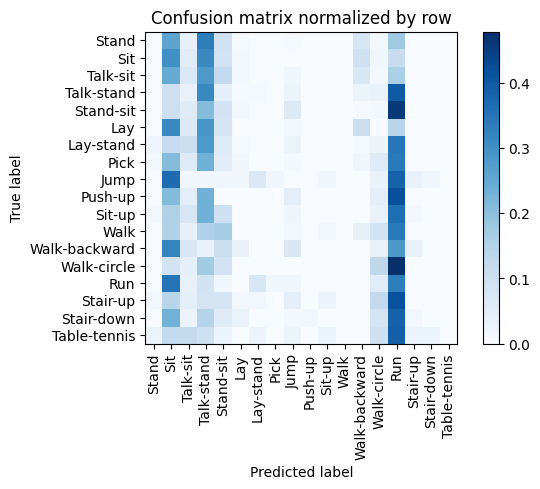

Overall accuracy: 0.082

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.119      0.087      0.100      0.105        196|	 Run: 0.459,	Talk-stand: 0.209,	Sit: 0.102,	
        Stand       0.000      0.000      0.000      0.091        170|	 Talk-stand: 0.335,	Sit: 0.259,	Run: 0.176,	
          Sit       0.132      0.302      0.184      0.090        169|	 Talk-stand: 0.314,	Run: 0.112,	
   Talk-stand       0.119      0.315      0.173      0.090        168|	 Run: 0.399,	Sit: 0.101,	
          Lay       0.000      0.000      0.000      0.087        163|	 Sit: 0.313,	Talk-stand: 0.288,	Run: 0.141,	
     Talk-sit       0.105      0.068      0.082      0.087        162|	 Talk-stand: 0.284,	Sit: 0.247,	Run: 0.160,	
    Lay-stand       0.000      0.000      0.000      0.085        159|	 Run: 0.346,	Talk-stand: 0.283,	Sit: 0.119,	
         Pick       0.000      0.000      0.000      0.064        120|	 Run: 0.342,	Talk-stand: 0.233,	Si

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-15 22:33:35,802 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 10.585669040679932 seconds

2022-09-15 22:33:35,803 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 10.585669040679932 seconds
2022-09-15 22:33:35,804 | INFO : Avg batch val. time: 0.17941811933355817 seconds
2022-09-15 22:33:35,805 | INFO : Avg sample val. time: 0.005666846381520306 seconds
2022-09-15 22:33:35,807 | INFO : Epoch 0 Validation Summary: epoch: 0.000000 | loss: 0.091336 | accuracy: 0.081906 | precision: 0.048906 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 




Distribution of classes with respect to PRECISION: 
[0.0, 0.2): 18
[0.2, 0.4): 0
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0


Distribution of classes with respect to RECALL: 
[0.0, 0.2): 15
[0.2, 0.4): 3
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0



Training Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1  99.8% | batch:       525 of       526	|	loss: 1.181359

2022-09-15 22:37:41,499 | INFO : Epoch 1 Training Summary: epoch: 1.000000 | loss: 0.047477 | 
2022-09-15 22:37:41,500 | INFO : Epoch runtime: 0.0 hours, 4.0 minutes, 5.5713417530059814 seconds

2022-09-15 22:37:41,501 | INFO : Avg epoch train. time: 0.0 hours, 4.0 minutes, 5.5713417530059814 seconds
2022-09-15 22:37:41,502 | INFO : Avg batch train. time: 0.4668656687319505 seconds
2022-09-15 22:37:41,503 | INFO : Avg sample train. time: 0.014612123155599547 seconds
2022-09-15 22:37:41,504 | INFO : Evaluating on validation set ...


Evaluating Epoch 1  98.3% | batch:        58 of        59	|	loss: 1.030873

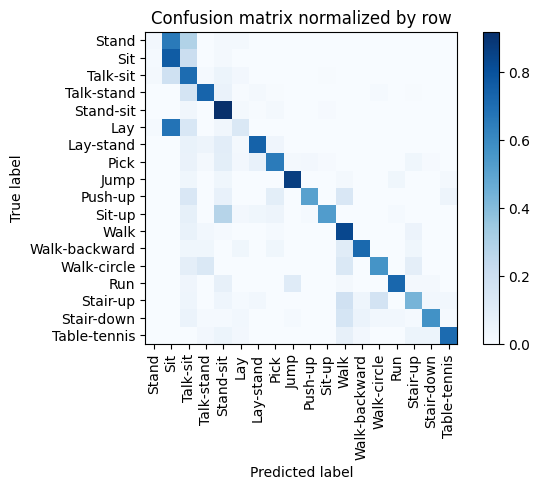

2022-09-15 22:37:48,872 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.366625547409058 seconds

2022-09-15 22:37:48,873 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.976147294044495 seconds
2022-09-15 22:37:48,874 | INFO : Avg batch val. time: 0.15213808972956772 seconds
2022-09-15 22:37:48,875 | INFO : Avg sample val. time: 0.004805218037497053 seconds
2022-09-15 22:37:48,877 | INFO : Epoch 1 Validation Summary: epoch: 1.000000 | loss: 0.033240 | accuracy: 0.603854 | precision: 0.645015 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  10%|█         | 1/10 [04:12<37:56, 252.98s/it]

Overall accuracy: 0.604

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.652      0.918      0.763      0.105        196|	 Talk-sit: 0.031,	Lay: 0.020,	
        Stand       0.364      0.024      0.044      0.091        170|	 Sit: 0.653,	Talk-sit: 0.288,	
          Sit       0.339      0.763      0.469      0.090        169|	 Talk-sit: 0.207,	Stand-sit: 0.018,	
   Talk-stand       0.866      0.732      0.794      0.090        168|	 Talk-sit: 0.161,	Stand-sit: 0.060,	
          Lay       0.468      0.135      0.210      0.087        163|	 Sit: 0.681,	Talk-sit: 0.141,	
     Talk-sit       0.376      0.704      0.490      0.087        162|	 Sit: 0.185,	Stand-sit: 0.049,	
    Lay-stand       0.874      0.742      0.803      0.085        159|	 Stand-sit: 0.094,	Talk-sit: 0.063,	
         Pick       0.796      0.650      0.716      0.064        120|	 Stand-sit: 0.092,	Lay-stand: 0.067,	
       Sit-up       0.923      0.527      0.

2022-09-15 22:41:37,256 | INFO : Epoch 2 Training Summary: epoch: 2.000000 | loss: 0.033643 | 
2022-09-15 22:41:37,257 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 48.34874606132507 seconds

2022-09-15 22:41:37,257 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 56.96004390716553 seconds
2022-09-15 22:41:37,259 | INFO : Avg batch train. time: 0.4504943800516455 seconds
2022-09-15 22:41:37,260 | INFO : Avg sample train. time: 0.014099728900819085 seconds
2022-09-15 22:41:37,261 | INFO : Evaluating on validation set ...


Evaluating Epoch 2  98.3% | batch:        58 of        59	|	loss: 0.733101

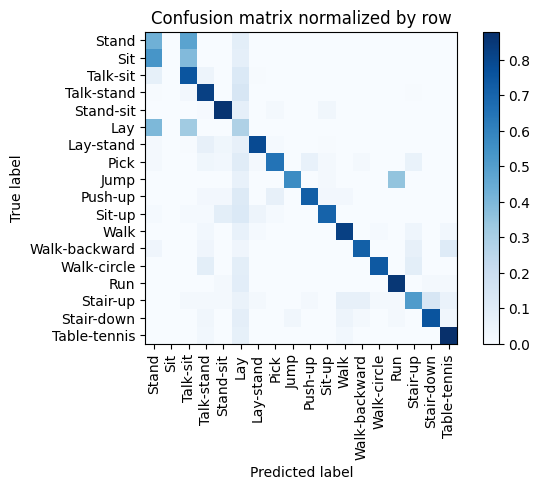

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-15 22:41:44,002 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.740997791290283 seconds

2022-09-15 22:41:44,002 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.23109745979309 seconds
2022-09-15 22:41:44,003 | INFO : Avg batch val. time: 0.13951012643717103 seconds
2022-09-15 22:41:44,003 | INFO : Avg sample val. time: 0.004406369089824995 seconds
2022-09-15 22:41:44,005 | INFO : Epoch 2 Validation Summary: epoch: 2.000000 | loss: 0.031313 | accuracy: 0.617773 | precision: 0.685556 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

Overall accuracy: 0.618

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.899      0.862      0.880      0.105        196|	 Lay: 0.077,	Sit-up: 0.031,	
        Stand       0.294      0.429      0.349      0.091        170|	 Talk-sit: 0.482,	Lay: 0.088,	
          Sit       0.000      0.000      0.000      0.090        169|	 Stand: 0.533,	Talk-sit: 0.391,	Lay: 0.077,	
   Talk-stand       0.798      0.821      0.809      0.090        168|	 Lay: 0.143,	Talk-sit: 0.024,	
          Lay       0.228      0.282      0.252      0.087        163|	 Stand: 0.399,	Talk-sit: 0.319,	
     Talk-sit       0.371      0.753      0.497      0.087        162|	 Lay: 0.123,	Stand: 0.074,	
    Lay-stand       0.933      0.786      0.853      0.085        159|	 Talk-stand: 0.069,	Lay: 0.069,	
         Pick       0.886      0.650      0.750      0.064        120|	 Lay: 0.100,	Push-up: 0.067,	
       Sit-up       0.853      0.703      0.771      0.049

2022-09-15 22:45:43,293 | INFO : Epoch 3 Training Summary: epoch: 3.000000 | loss: 0.030550 | 
2022-09-15 22:45:43,294 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 59.26654505729675 seconds

2022-09-15 22:45:43,295 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 57.728877623875945 seconds
2022-09-15 22:45:43,299 | INFO : Avg batch train. time: 0.4519560411100303 seconds
2022-09-15 22:45:43,301 | INFO : Avg sample train. time: 0.014145476474109006 seconds
2022-09-15 22:45:43,302 | INFO : Evaluating on validation set ...


Evaluating Epoch 3  98.3% | batch:        58 of        59	|	loss: 0.685021

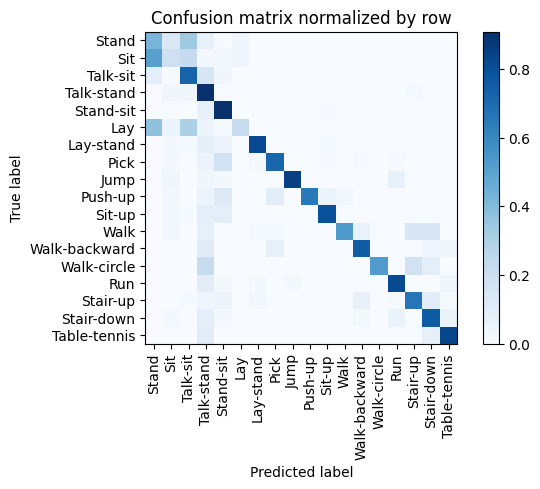

2022-09-15 22:45:51,634 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 8.330518960952759 seconds

2022-09-15 22:45:51,635 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.255952835083008 seconds
2022-09-15 22:45:51,635 | INFO : Avg batch val. time: 0.13993140398445775 seconds
2022-09-15 22:45:51,636 | INFO : Avg sample val. time: 0.004419674965247863 seconds
2022-09-15 22:45:51,640 | INFO : Epoch 3 Validation Summary: epoch: 3.000000 | loss: 0.029689 | accuracy: 0.646681 | precision: 0.686937 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  30%|███       | 3/10 [12:15<28:33, 244.83s/it]

Overall accuracy: 0.647

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.745      0.908      0.818      0.105        196|	 Talk-stand: 0.071,	Sit-up: 0.010,	
        Stand       0.309      0.424      0.357      0.091        170|	 Talk-sit: 0.335,	Sit: 0.129,	
          Sit       0.390      0.189      0.255      0.090        169|	 Stand: 0.509,	Talk-sit: 0.225,	
   Talk-stand       0.553      0.905      0.686      0.090        168|	 Talk-sit: 0.036,	Sit: 0.030,	
          Lay       0.714      0.215      0.330      0.087        163|	 Stand: 0.374,	Talk-sit: 0.294,	
     Talk-sit       0.435      0.728      0.545      0.087        162|	 Talk-stand: 0.142,	Stand: 0.086,	
    Lay-stand       0.942      0.818      0.875      0.085        159|	 Talk-stand: 0.082,	Stand-sit: 0.050,	
         Pick       0.905      0.717      0.800      0.064        120|	 Stand-sit: 0.175,	Talk-stand: 0.050,	
       Sit-up       0.911      0.791     

2022-09-15 22:50:07,121 | INFO : Epoch 4 Training Summary: epoch: 4.000000 | loss: 0.029564 | 
2022-09-15 22:50:07,122 | INFO : Epoch runtime: 0.0 hours, 4.0 minutes, 15.457843780517578 seconds

2022-09-15 22:50:07,123 | INFO : Avg epoch train. time: 0.0 hours, 4.0 minutes, 2.1611191630363464 seconds
2022-09-15 22:50:07,125 | INFO : Avg batch train. time: 0.46038235582326303 seconds
2022-09-15 22:50:07,127 | INFO : Avg sample train. time: 0.014409206186066663 seconds
2022-09-15 22:50:07,128 | INFO : Evaluating on validation set ...


Evaluating Epoch 4  98.3% | batch:        58 of        59	|	loss: 0.473745

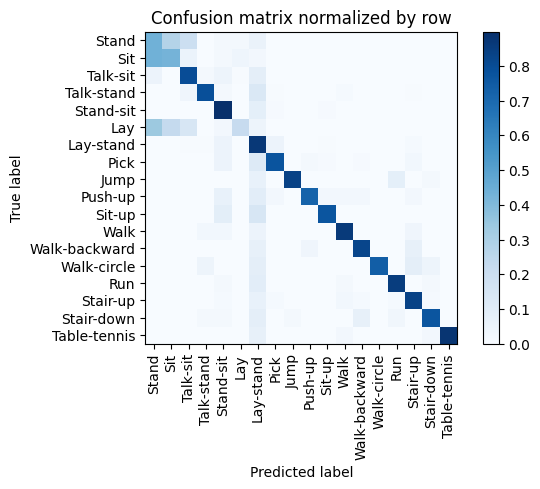

2022-09-15 22:50:15,005 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.8749001026153564 seconds

2022-09-15 22:50:15,006 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.179742288589477 seconds
2022-09-15 22:50:15,011 | INFO : Avg batch val. time: 0.1386396998066013 seconds
2022-09-15 22:50:15,011 | INFO : Avg sample val. time: 0.0043788770281528245 seconds
2022-09-15 22:50:15,013 | INFO : Epoch 4 Validation Summary: epoch: 4.000000 | loss: 0.024807 | accuracy: 0.699143 | precision: 0.733672 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  40%|████      | 4/10 [16:39<25:12, 252.16s/it]

Overall accuracy: 0.699

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.779      0.898      0.834      0.105        196|	 Lay-stand: 0.082,	Pick: 0.010,	
        Stand       0.351      0.435      0.388      0.091        170|	 Sit: 0.276,	Talk-sit: 0.194,	
          Sit       0.462      0.426      0.443      0.090        169|	 Stand: 0.438,	Talk-sit: 0.053,	
   Talk-stand       0.943      0.792      0.861      0.090        168|	 Lay-stand: 0.131,	Talk-sit: 0.036,	
          Lay       0.766      0.221      0.343      0.087        163|	 Stand: 0.337,	Sit: 0.227,	
     Talk-sit       0.639      0.796      0.709      0.087        162|	 Lay-stand: 0.086,	Stand: 0.049,	
    Lay-stand       0.505      0.868      0.639      0.085        159|	 Pick: 0.050,	Stand-sit: 0.050,	
         Pick       0.877      0.775      0.823      0.064        120|	 Lay-stand: 0.117,	Stand-sit: 0.050,	
       Sit-up       0.933      0.769      0.843    

KeyboardInterrupt: 

In [13]:
# Evaluate on validation before training
aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config, best_metrics,
                                                        best_value, epoch=0, class_names=config['class_names'])
metrics_names, metrics_values = zip(*aggr_metrics_val.items())
metrics.append(list(metrics_values))

logger.info('Starting training...')
for epoch in tqdm(range(start_epoch + 1, config["epochs"] + 1), desc='Training Epoch', leave=False):
    mark = epoch if config['save_all'] else 'last'
    epoch_start_time = time.time()
    aggr_metrics_train = trainer.train_epoch(epoch)  # dictionary of aggregate epoch metrics
    # print(f"train metrics >> {aggr_metrics_train}")
    run['train/loss'].log(aggr_metrics_train['loss'])
    epoch_runtime = time.time() - epoch_start_time
    print_str = 'Epoch {} Training Summary: '.format(epoch)
    for k, v in aggr_metrics_train.items():
        tensorboard_writer.add_scalar('{}/train'.format(k), v, epoch)
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    logger.info("Epoch runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(epoch_runtime)))
    total_epoch_time += epoch_runtime
    avg_epoch_time = total_epoch_time / (epoch - start_epoch)
    avg_batch_time = avg_epoch_time / len(train_loader)
    avg_sample_time = avg_epoch_time / len(train_dataset)
    logger.info("Avg epoch train. time: {} hours, {} minutes, {} seconds".format(*utils.readable_time(avg_epoch_time)))
    logger.info("Avg batch train. time: {} seconds".format(avg_batch_time))
    logger.info("Avg sample train. time: {} seconds".format(avg_sample_time))

    # evaluate if first or last epoch or at specified interval
    if (epoch == config["epochs"]) or (epoch == start_epoch + 1) or (epoch % config['val_interval'] == 0):
        aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config,
                                                                best_metrics, best_value, epoch, config['class_names'])
        # print(f"eval metrics >> {aggr_metrics_val}")
        run['eval/loss'].log(aggr_metrics_val['loss'])
        run['eval/accuracy'].log(aggr_metrics_val['accuracy'])
        run['eval/precision'].log(aggr_metrics_val['precision'])
        metrics_names, metrics_values = zip(*aggr_metrics_val.items())
        metrics.append(list(metrics_values))

    # utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(mark)), epoch, model, optimizer)

    # Learning rate scheduling
    if epoch == config['lr_step'][lr_step]:
        utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(epoch)), epoch, model, optimizer)
        lr = lr * config['lr_factor'][lr_step]
        if lr_step < len(config['lr_step']) - 1:  # so that this index does not get out of bounds
            lr_step += 1
        logger.info('Learning rate updated to: ', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Difficulty scheduling
    if config['harden'] and check_progress(epoch):
        train_loader.dataset.update()
        val_loader.dataset.update()

# Export evolution of metrics over epochs
# header = metrics_names #@nipdep
# metrics_filepath = os.path.join(config["output_dir"], "metrics_" + config["experiment_name"] + ".xls")
# book = utils.export_performance_metrics(metrics_filepath, metrics, header, sheet_name="metrics")

# # Export record metrics to a file accumulating records from all experiments
# utils.register_record(config["records_file"], config["initial_timestamp"], config["experiment_name"],
#                         best_metrics, aggr_metrics_val, comment=config['comment'])

logger.info('Best {} was {}. Other metrics: {}'.format(config['key_metric'], best_value, best_metrics))
logger.info('All Done!')

total_runtime = time.time() - total_start_time
logger.info("Total runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(total_runtime)))

run.stop()

In [ ]:
model.train()
for i in val_loader:
    x, y, m, ids = i
    x = x.to(device)
    m = m.to(device)
    pred = model(x, m)
    break

In [ ]:
pred.shape

torch.Size([32, 18])

In [ ]:
probs = torch.softmax(pred, dim=-1)
pred_label = torch.argmax(probs, dim=-1)
pred_label.shape

torch.Size([32])

In [ ]:
pred_label

tensor([ 3,  2, 14,  4,  4,  1,  4,  3, 15, 17,  4, 11, 17,  1,  1, 15,  1, 10,
         1,  1,  3,  6,  1, 15,  6,  6, 15,  6,  1, 15,  1,  1],
       device='cuda:0')

In [ ]:
y

tensor([13,  2, 14,  4,  4,  1,  4,  3, 15, 17,  4, 11, 17,  1,  5, 11,  5,  4,
         0,  2,  3,  6,  5, 12,  4,  9, 15, 10,  1, 15,  2,  0])

In [ ]:
model.transformer_encoder.layers[0].linear1.weight.grad

tensor([[ 1.9982e-03,  1.8686e-03, -7.6950e-03,  ...,  3.2540e-05,
          2.5046e-03, -1.7847e-03],
        [ 1.0441e-02, -2.4760e-02, -1.4667e-02,  ..., -5.1662e-03,
          6.1747e-04, -1.9824e-02],
        [-4.3647e-03,  1.7393e-02,  1.9783e-03,  ...,  3.0929e-03,
          2.6371e-03, -6.4250e-03],
        ...,
        [ 1.8496e-02, -1.9215e-02, -2.6746e-02,  ...,  2.0559e-02,
         -1.6608e-02,  1.2978e-02],
        [ 1.7822e-02,  5.6438e-02,  3.2866e-02,  ...,  1.7167e-02,
         -6.8521e-03,  2.6117e-02],
        [-1.5895e-02, -5.7300e-03, -1.0521e-02,  ..., -1.7554e-02,
          2.3200e-02,  2.8165e-03]], device='cuda:0')

In [ ]:
model

TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerBatchNormEncoderLayer(

In [ ]:
# test 1D-Conv layer
from torch import nn


In [ ]:
conv_layer = nn.Conv1d(300, 1, 1)
sample_inp = torch.rand((32, 300, 128))
sample_out = conv_layer(sample_inp)
sample_out.shape

torch.Size([32, 1, 128])